In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import seaborn as sns
# Inspired by https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import numpyro
import numpyro.distributions as dist
from numpyro.callbacks import Progbar
from numpyro.infer import ELBO, Stein
from numpyro.infer.guide import WrappedGuide
from numpyro.infer.kernels import RBFKernel
from numpyro.optim import Adam

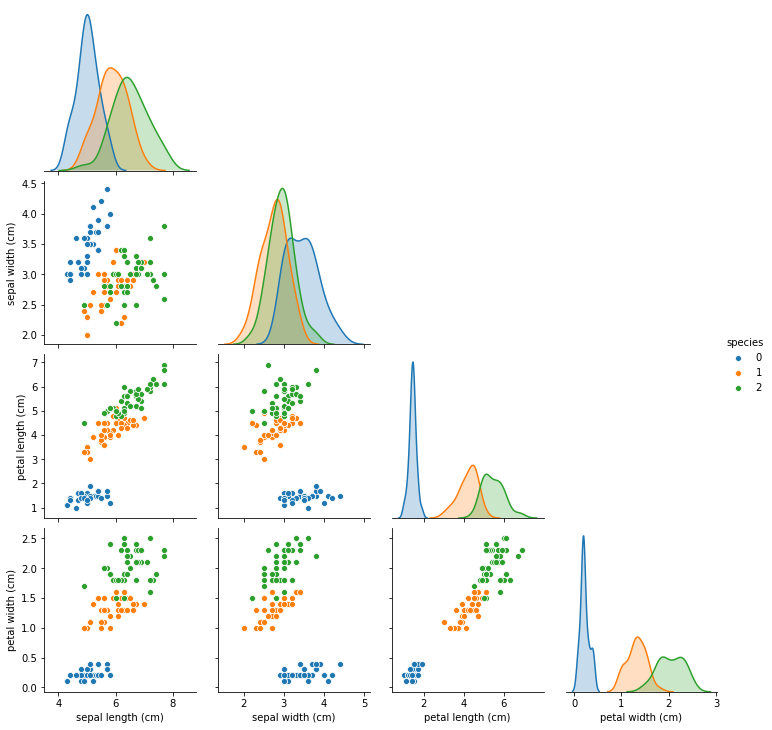

In [2]:
data = load_iris(as_frame=True)
X_train, X_test, y_train, y_test = \
    train_test_split(data.data, data.target)
data_plot = X_train.copy()
data_plot['species'] = y_train
sns.pairplot(data_plot, hue='species', corner=True)

In [3]:
def model(X, y=None):
    W1 = numpyro.sample('W1', dist.Normal(jnp.zeros((4, 3)), jnp.ones((4, 3))).to_event(2))
    b1 = numpyro.sample('b1', dist.Normal(jnp.zeros(3), jnp.ones(3)).to_event(1))
    logodds = X @ W1 + b1
    with numpyro.plate('data', X.shape[0]):
        numpyro.sample('y', dist.Categorical(logits=logodds), obs=y)

In [4]:
def guide(X, y=None):
    W1loc = numpyro.param('W1loc', jnp.zeros((4, 3)))
    W1scale = numpyro.param('W1scale', jnp.ones((4, 3)),
                            constraint=dist.constraints.positive)
    b1loc = numpyro.param('b1loc', jnp.zeros(3))
    b1scale = numpyro.param('b1scale', jnp.ones(3),
                            constraint=dist.constraints.positive)
    W1 = numpyro.sample('W1', dist.Normal(W1loc, W1scale).to_event(2))
    b1 = numpyro.sample('b1', dist.Normal(b1loc, b1scale).to_event(1))

In [5]:
svgd = Stein(model, WrappedGuide(guide), Adam(0.1), ELBO(), RBFKernel(),
             num_particles=100)
state, loss = svgd.train(jax.random.PRNGKey(1337), 15_000, X_train.to_numpy(), y_train.to_numpy(),
                         callbacks=[Progbar()])

Stein 63.8: 100%|██████████| 15000/15000 [04:02<00:00, 61.80it/s]  


In [6]:
y_pred = svgd.predict(state, X_test.to_numpy())['y']
print(f"Accuracy: {np.mean(y_pred == y_test.to_numpy())*100:.2f} %")

Accuracy: 89.37 %
